<a href="https://colab.research.google.com/github/SydAt1/Emotion_Detection_AML/blob/main/retraining_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retraining DistilBERT

Main objective of retraining is that the accuracy before were very poor with the original 28 emotions so combining emotions into the following categories:

* Positive

* Negative

* Uncertain

* Neutral

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-multilearn transformers torch tqdm

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split
from tqdm import tqdm
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.8 MB/s eta 0:00:00


In [3]:
base_path = '/content/drive/MyDrive/Text_Emotion_Classifier'
dataset_path = os.path.join(base_path, 'dataset/preprocessed_go_emotions.csv')

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
LEARNING_RATE = 1e-5  # Slightly lower for continued fine-tuning
EPOCHS = 10
PATIENCE = 3
MAX_LENGTH = 128  # Better context than 64

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Text_Emotion_Classifier/dataset/preprocessed_go_emotions.csv')
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise'
]

In [ ]:
df.head()

,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,cleaned_text
0,That game hurt.,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,game hurt
1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,right not care fuck em
2,Man I love reddit.,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,man love reddit
3,"[NAME] was nowhere near them, he was by the Fa...",False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,near falcon
4,Right? Considering it’s such an important docu...,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,right consider important document know damned ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207814 entries, 0 to 207813
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   text                  207814 non-null  object
 1   example_very_unclear  207814 non-null  bool  
 2   admiration            207814 non-null  int64 
 3   amusement             207814 non-null  int64 
 4   anger                 207814 non-null  int64 
 5   annoyance             207814 non-null  int64 
 6   approval              207814 non-null  int64 
 7   caring                207814 non-null  int64 
 8   confusion             207814 non-null  int64 
 9   curiosity             207814 non-null  int64 
 10  desire                207814 non-null  int64 
 11  disappointment        207814 non-null  int64 
 12  disapproval           207814 non-null  int64 
 13  disgust               207814 non-null  int64 
 14  embarrassment         207814 non-null  int64 
 15  excitement       

In [5]:
# Get counts for each emotion
emotion_counts = df[emotion_columns].sum().sort_values(ascending=False)

print("Emotion Distribution:")
print(emotion_counts)
print(f"\nTotal samples: {len(df)}")

Emotion Distribution:
approval          17620
admiration        17131
annoyance         13618
gratitude         11625
disapproval       11424
curiosity          9692
amusement          9245
realization        8785
optimism           8715
disappointment     8469
love               8191
anger              8084
joy                7983
confusion          7359
sadness            6758
caring             5999
excitement         5629
surprise           5514
disgust            5301
desire             3817
fear               3197
remorse            2525
embarrassment      2476
nervousness        1810
pride              1302
relief             1289
grief               673
dtype: int64

Total samples: 207814


## Combining Similar Emotions

There is a class imbalance and in the previous DistilBERT training we saw that the accuracy could really do better.

In [6]:
# Simpler 4-way grouping
emotion_groups_simple = {
    'positive': ['admiration', 'amusement', 'approval', 'excitement', 'gratitude',
                 'joy', 'love', 'optimism', 'pride', 'relief', 'caring', 'desire'],

    'negative': ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust',
                 'sadness', 'embarrassment', 'remorse', 'grief', 'fear', 'nervousness'],

    'uncertain': ['confusion', 'curiosity', 'realization', 'surprise'],

    'neutral': ['neutral']
}

In [7]:
for group_name, emotions in emotion_groups_simple.items():
    df[group_name] = df[emotions].max(axis=1)

# Check distribution
group_columns = list(emotion_groups_simple.keys())
group_counts = df[group_columns].sum().sort_values(ascending=False)

print("\nSimplified Grouped Distribution:")
for col in group_columns:
    count = df[col].sum()
    percentage = (count / len(df)) * 100
    print(f"{col}: {count:,} ({percentage:.2f}%)")


Simplified Grouped Distribution:
positive: 82,938 (39.91%)
negative: 54,798 (26.37%)
uncertain: 29,282 (14.09%)
neutral: 55,298 (26.61%)


In [8]:
df.drop(columns=emotion_columns, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207814 entries, 0 to 207813
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   text                  207814 non-null  object
 1   example_very_unclear  207814 non-null  bool  
 2   neutral               207814 non-null  int64 
 3   cleaned_text          206698 non-null  object
 4   positive              207814 non-null  int64 
 5   negative              207814 non-null  int64 
 6   uncertain             207814 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 9.7+ MB


Saving this new dataset for training other algorithms

In [ ]:
df.to_csv(os.path.join(base_path, 'dataset/new_emotions_dataset.csv'), index=False)

In [14]:
emotion_labels = list(emotion_groups_simple.keys())


In [ ]:
X = df['cleaned_text'].values.reshape(-1, 1)
labels = df[emotion_labels].values.astype('float32')

In [ ]:
# Stratified split
X_train, y_train, X_test, y_test = iterative_train_test_split(X, labels, test_size=0.2)
val_size = 0.2
X_train, y_train, X_val, y_val = iterative_train_test_split(X_train, y_train, test_size=val_size / (1 - 0.2))

# Convert to flat lists of strings
X_train = [str(x[0]) for x in X_train]
X_val   = [str(x[0]) for x in X_val]
X_test  = [str(x[0]) for x in X_test]

In [ ]:
# Train-Val-Test split size

print(f"Train size: {len(X_train)}")
print(f"Val size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 124694
Val size: 41564
Test size: 41556


Saving the train, val and test split in a numpy array

In [ ]:
np.save("/content/drive/MyDrive/Text_Emotion_Classifier/model/train-test-val/train_idx.npy", X_train)
np.save("/content/drive/MyDrive/Text_Emotion_Classifier/model/train-test-val/val_idx.npy", X_val)
np.save("/content/drive/MyDrive/Text_Emotion_Classifier/model/train-test-val/test_idx.npy", X_test)


Load the train, val and test split

In [ ]:
SAVE_DIR = "/content/drive/MyDrive/Text_Emotion_Classifier/model/train-test-val"

X_train = np.load(f"{SAVE_DIR}/train_idx.npy", allow_pickle=True)
X_val   = np.load(f"{SAVE_DIR}/val_idx.npy", allow_pickle=True)
X_test  = np.load(f"{SAVE_DIR}/test_idx.npy", allow_pickle=True)

# X_train = X[train_idx]
y_train = labels[train_idx]

# X_val   = X[val_idx]
y_val   = labels[val_idx]

# X_test  = X[test_idx]
y_test  = labels[test_idx]

## Load the Model and the Tokenizer

In [ ]:
# Initialize fresh DistilBERT model with 4 labels (not loading pretrained)
MODEL_NAME = "distilbert-base-uncased"
NUM_LABELS = len(emotion_labels)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model.to(DEVICE)
print(f"Successfully loaded {MODEL_NAME} with {NUM_LABELS} labels: {emotion_labels}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully loaded distilbert-base-uncased with 4 labels: ['positive', 'negative', 'uncertain', 'neutral']


## Dataset and DataLoader

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Tokenize
def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

In [ ]:
print("Tokenizing datasets...")
train_encodings = tokenize_texts(X_train)
val_encodings   = tokenize_texts(X_val)
test_encodings  = tokenize_texts(X_test)

train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset   = EmotionDataset(val_encodings, y_val)
test_dataset  = EmotionDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("Datasets ready!")

Tokenizing datasets...
Datasets ready!


## Training Setup

In [ ]:
# Optimizer & Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.BCEWithLogitsLoss()

# Training functions
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs.logits).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(loader), np.array(all_preds), np.array(all_labels)

## Training Loop

In [ ]:
# Create save directory
SAVE_DIR = os.path.join(base_path, 'model/grouped_emotions_distilbert')
os.makedirs(SAVE_DIR, exist_ok=True)

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0

# Track training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': []
}

In [ ]:
print("Starting training with Early Stopping...")
print(f"Maximum epochs: {EPOCHS}")
print(f"Patience: {PATIENCE} epochs")
print(f"Emotion labels: {emotion_labels}\n")

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")

    # Training
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn)

    # Validation
    val_loss, val_preds, val_labels = evaluate(model, val_loader, loss_fn)

    # Calculate accuracy (with 0.5 threshold)
    val_preds_binary = (val_preds > 0.5).astype(int)
    accuracy = (val_preds_binary == val_labels).mean()

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(accuracy)

    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Accuracy: {accuracy:.4f}")

    # Save checkpoint every epoch
    checkpoint_path = os.path.join(SAVE_DIR, f"checkpoint_epoch_{epoch}")
    model.save_pretrained(checkpoint_path)
    tokenizer.save_pretrained(checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

    # Check for improvement
    if val_loss < best_val_loss:
        improvement = best_val_loss - val_loss
        best_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0

        # Save best model
        best_path = os.path.join(SAVE_DIR, "best_model")
        model.save_pretrained(best_path)
        tokenizer.save_pretrained(best_path)

        print(f"✓ New best model saved! (Improved by {improvement:.4f})")
        print(f"  Best Val Loss: {best_val_loss:.4f} at epoch {best_epoch}")
    else:
        patience_counter += 1
        print(f"✗ No improvement. Patience counter: {patience_counter}/{PATIENCE}")
        print(f"  Best Val Loss: {best_val_loss:.4f} at epoch {best_epoch}")

        # Early stopping check
        if patience_counter >= PATIENCE:
            print(f"\n{'='*60}")
            print(f"EARLY STOPPING TRIGGERED!")
            print(f"No improvement for {PATIENCE} consecutive epochs")
            print(f"Best model was at epoch {best_epoch} with val loss {best_val_loss:.4f}")
            print(f"{'='*60}")
            break

print("Training completed!")
print(f"Total epochs trained: {epoch}")
print(f"Best validation loss: {best_val_loss:.4f} (epoch {best_epoch})")
print(f"Best model saved at: {os.path.join(SAVE_DIR, 'best_model')}")
print("="*60)

Starting training with Early Stopping...
Maximum epochs: 10
Patience: 3 epochs
Emotion labels: ['positive', 'negative', 'uncertain', 'neutral']

Epoch 1/10


Training: 100%|██████████| 7793/7793 [21:49<00:00,  5.95it/s]



Train Loss: 0.4544
Val Loss: 0.4423
Val Accuracy: 0.7991
Checkpoint saved: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_distilbert/checkpoint_epoch_1
✓ New best model saved! (Improved by inf)
  Best Val Loss: 0.4423 at epoch 1
Epoch 2/10


Training: 100%|██████████| 7793/7793 [21:50<00:00,  5.95it/s]



Train Loss: 0.4301
Val Loss: 0.4426
Val Accuracy: 0.7994
Checkpoint saved: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_distilbert/checkpoint_epoch_2
✗ No improvement. Patience counter: 1/3
  Best Val Loss: 0.4423 at epoch 1
Epoch 3/10


Training: 100%|██████████| 7793/7793 [21:51<00:00,  5.94it/s]



Train Loss: 0.4091
Val Loss: 0.4452
Val Accuracy: 0.7980
Checkpoint saved: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_distilbert/checkpoint_epoch_3
✗ No improvement. Patience counter: 2/3
  Best Val Loss: 0.4423 at epoch 1
Epoch 4/10


Training: 100%|██████████| 7793/7793 [21:51<00:00,  5.94it/s]



Train Loss: 0.3868
Val Loss: 0.4522
Val Accuracy: 0.7980
Checkpoint saved: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_distilbert/checkpoint_epoch_4
✗ No improvement. Patience counter: 3/3
  Best Val Loss: 0.4423 at epoch 1

EARLY STOPPING TRIGGERED!
No improvement for 3 consecutive epochs
Best model was at epoch 1 with val loss 0.4423
Training completed!
Total epochs trained: 4
Best validation loss: 0.4423 (epoch 1)
Best model saved at: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_distilbert/best_model


In [ ]:
# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(os.path.join(SAVE_DIR, 'training_history.csv'), index=False)
print(f"\nTraining history saved to: {os.path.join(SAVE_DIR, 'training_history.csv')}")


Training history saved to: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_distilbert/training_history.csv


In [ ]:
history_df

,train_loss,val_loss,val_accuracy
0,0.454431,0.442287,0.799092
1,0.430148,0.442636,0.799417
2,0.409072,0.445244,0.797962
3,0.386822,0.452217,0.797986


## Visualize Training History

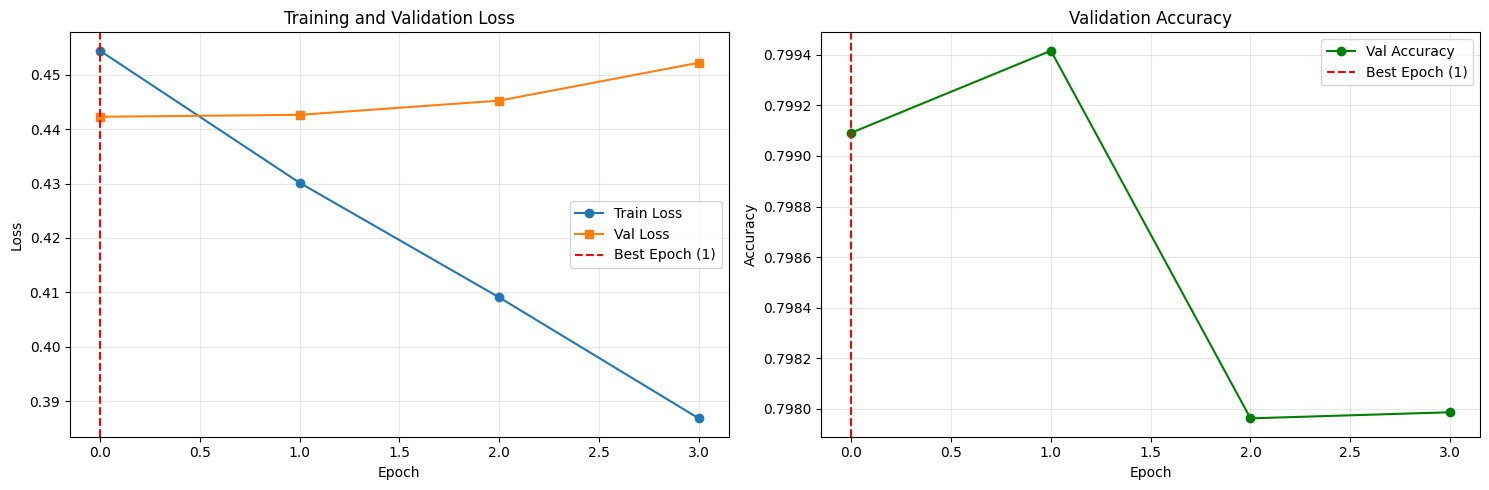

Training curves saved to: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_distilbert/training_curves.png


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].axvline(x=best_epoch-1, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
axes[1].axvline(x=best_epoch-1, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Training curves saved to: {os.path.join(SAVE_DIR, 'training_curves.png')}")

## Final Evaluation on Test Set

In [ ]:
best_model = AutoModelForSequenceClassification.from_pretrained(
    os.path.join(SAVE_DIR, "best_model")
)
best_model.to(DEVICE)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_preds, test_labels = evaluate(best_model, test_loader, loss_fn)
test_preds_binary = (test_preds > 0.5).astype(int)
test_accuracy = (test_preds_binary == test_labels).mean()

Evaluating on test set...


In [ ]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4412
Test Accuracy: 0.8010


### Per Emotion Metrics

In [ ]:
from sklearn.metrics import classification_report, hamming_loss, f1_score

print("\nPer-Emotion Classification Report:")
print(classification_report(test_labels, test_preds_binary,
                          target_names=emotion_labels,
                          zero_division=0))



Per-Emotion Classification Report:
              precision    recall  f1-score   support

    positive       0.78      0.66      0.72     16588
    negative       0.65      0.53      0.59     10960
   uncertain       0.62      0.13      0.21      5856
     neutral       0.58      0.19      0.29     11060

   micro avg       0.70      0.44      0.54     44464
   macro avg       0.66      0.38      0.45     44464
weighted avg       0.68      0.44      0.51     44464
 samples avg       0.47      0.45      0.45     44464



In [ ]:
# Additional metrics
hamming = hamming_loss(test_labels, test_preds_binary)
f1_micro = f1_score(test_labels, test_preds_binary, average='micro', zero_division=0)
f1_macro = f1_score(test_labels, test_preds_binary, average='macro', zero_division=0)

print(f"\nAdditional Metrics:")
print(f"Hamming Loss: {hamming:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")


Additional Metrics:
Hamming Loss: 0.1990
F1 Score (Micro): 0.5439
F1 Score (Macro): 0.4502


In [ ]:
metrics_summary = {
    'best_epoch': best_epoch,
    'best_val_loss': best_val_loss,
    'test_loss': test_loss,
    'test_accuracy': test_accuracy,
    'hamming_loss': hamming,
    'f1_micro': f1_micro,
    'f1_macro': f1_macro,
    'total_epochs_trained': epoch,
    'early_stopped': epoch < EPOCHS
}

metrics_df = pd.DataFrame([metrics_summary])
metrics_df.to_csv(os.path.join(SAVE_DIR, 'metrics_summary.csv'), index=False)
print(f"Metrics summary saved to: {os.path.join(SAVE_DIR, 'metrics_summary.csv')}")

Metrics summary saved to: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_distilbert/metrics_summary.csv


### ROC and AUC Curves

In [ ]:
from sklearn.metrics import roc_curve, auc



AUC Scores:
positive: 0.845
negative: 0.837
uncertain: 0.724
neutral: 0.738


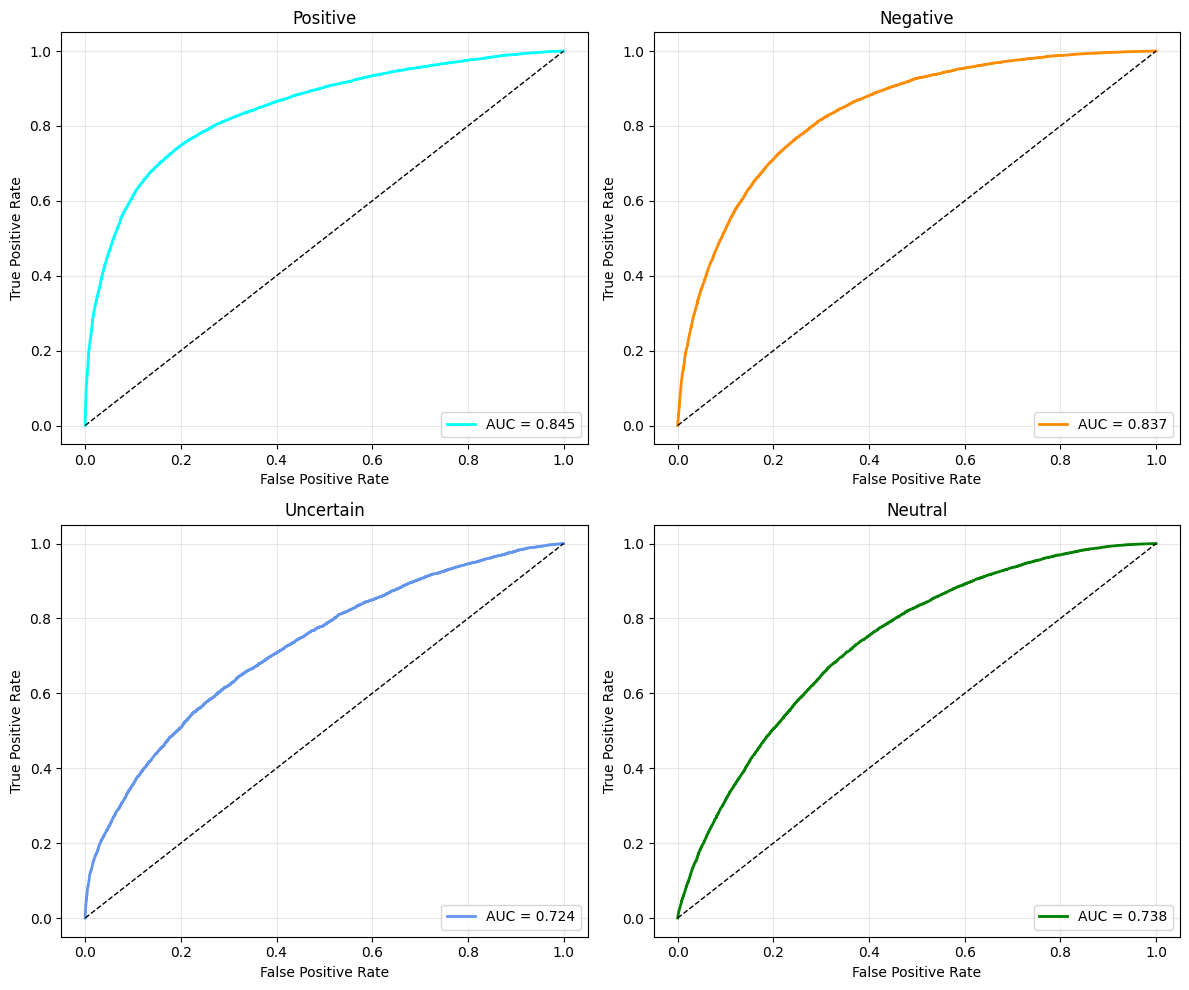

In [ ]:
# Calculate ROC and AUC for each emotion
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']

print("\nAUC Scores:")
for i, (label, color, ax) in enumerate(zip(emotion_labels, colors, axes)):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_preds[:, i])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=color, lw=2, label=f'AUC = {roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_title(f'{label.capitalize()}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)

    print(f"{label}: {roc_auc:.3f}")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'roc_curves.png'), dpi=300)
plt.show()


AUC Scores:
positive: 0.845
negative: 0.837
uncertain: 0.724
neutral: 0.738


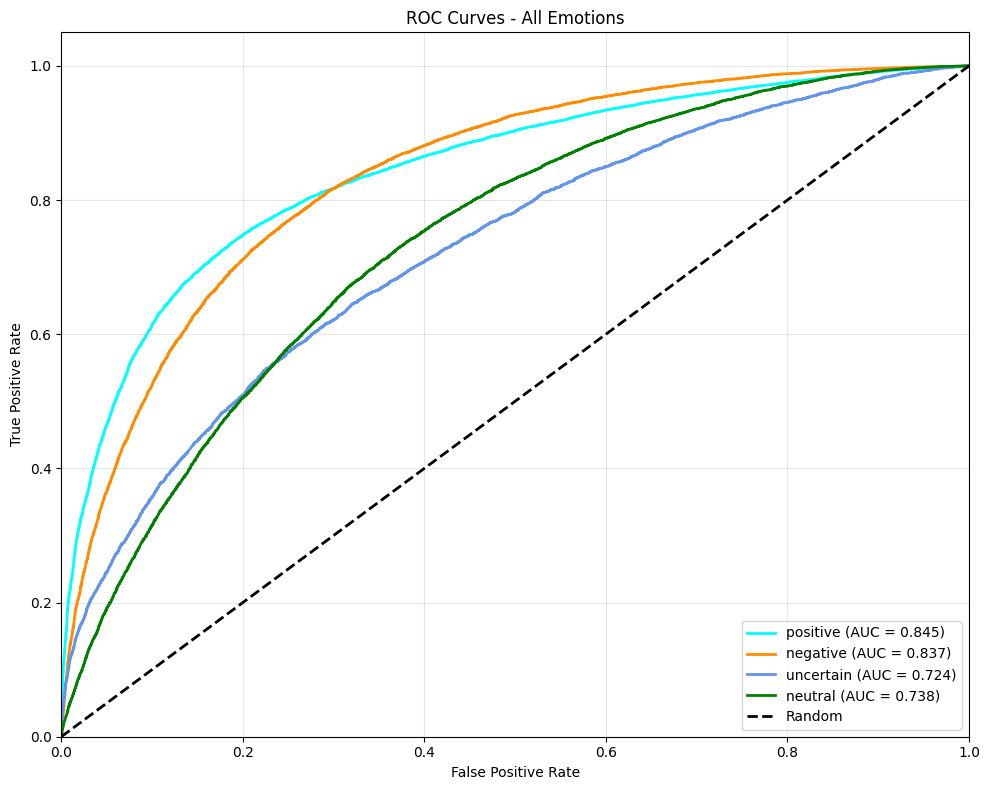

In [ ]:
# Plot all curves in one graph
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']

print("\nAUC Scores:")
for i, (label, color) in enumerate(zip(emotion_labels, colors)):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.3f})')
    print(f"{label}: {roc_auc:.3f}")

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Emotions')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'roc_curves.png'), dpi=300)
plt.show()

## Test Model on Sample Sentences

In [ ]:
# Sample sentences to test
test_sentences = [
    "I'm so happy and excited about my new job!",
    "This is absolutely terrible, I can't believe this happened.",
    "I'm not really sure what to think about this situation.",
    "Just another day at work, nothing special.",
    "I love spending time with my family on weekends.",
    "I'm really angry and frustrated with how things turned out.",
    "What do you think about the new policy changes?",
    "Everything is fine, just going through the motions.",
]

In [ ]:
# Tokenize and predict
inputs = tokenizer(test_sentences, truncation=True, padding='max_length',
                   max_length=MAX_LENGTH, return_tensors='pt')
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

In [ ]:
best_model.eval()
with torch.no_grad():
    outputs = best_model(**inputs)
    predictions = torch.sigmoid(outputs.logits).cpu().numpy()

In [ ]:
for sentence, pred in zip(test_sentences, predictions):
    print(f"\nSentence: {sentence}")
    print("Predictions:")
    max_idx = pred.argmax()
    for i, (label, score) in enumerate(zip(emotion_labels, pred)):
        if i == max_idx:
            print(f"  ✓ {label}: {score:.3f}")
        else:
            print(f"    {label}: {score:.3f}")


Sentence: I'm so happy and excited about my new job!
Predictions:
  ✓ positive: 0.961
    negative: 0.012
    uncertain: 0.031
    neutral: 0.028

Sentence: This is absolutely terrible, I can't believe this happened.
Predictions:
    positive: 0.072
  ✓ negative: 0.777
    uncertain: 0.192
    neutral: 0.076

Sentence: I'm not really sure what to think about this situation.
Predictions:
    positive: 0.087
    negative: 0.267
  ✓ uncertain: 0.482
    neutral: 0.231

Sentence: Just another day at work, nothing special.
Predictions:
    positive: 0.263
    negative: 0.277
    uncertain: 0.121
  ✓ neutral: 0.344

Sentence: I love spending time with my family on weekends.
Predictions:
  ✓ positive: 0.869
    negative: 0.024
    uncertain: 0.028
    neutral: 0.098

Sentence: I'm really angry and frustrated with how things turned out.
Predictions:
    positive: 0.092
  ✓ negative: 0.816
    uncertain: 0.066
    neutral: 0.097

Sentence: What do you think about the new policy changes?
Predic

## Entire Pipeline to load and run the Model

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Path to saved model
MODEL_PATH = "/content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_distilbert/best_model"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model.to(DEVICE)
model.eval()

# Emotion labels
emotion_labels = ['positive', 'negative', 'uncertain', 'neutral']

print(f"Model loaded from: {MODEL_PATH}")
print(f"Emotion labels: {emotion_labels}")

# Test on a sentence
def predict_emotion(text):
    inputs = tokenizer(text, truncation=True, padding='max_length',
                      max_length=128, return_tensors='pt')
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]

    max_idx = probs.argmax()
    for i, (label, score) in enumerate(zip(emotion_labels, probs)):
        if i == max_idx:
            print(f"  ✓ {label}: {score:.3f}")
        else:
            print(f"    {label}: {score:.3f}")

# Example usage
predict_emotion("I'm so happy today!")

Model loaded from: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_distilbert/best_model
Emotion labels: ['positive', 'negative', 'uncertain', 'neutral']
  ✓ positive: 0.953
    negative: 0.015
    uncertain: 0.019
    neutral: 0.032


January 10th 2026

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_distilbert/best_model"
LABELS = ['positive', 'negative', 'uncertain', 'neutral']

model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
def predict(texts, bs=16):
    preds = []
    for i in range(0, len(texts), bs):
        enc = tokenizer(texts[i:i+bs], padding=True, truncation=True,
                        max_length=128, return_tensors='pt').to(DEVICE)
        with torch.no_grad():
            preds.append(torch.sigmoid(model(**enc).logits).cpu().numpy())
    return np.vstack(preds)

probs = predict(X_test)
y_pred = probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)


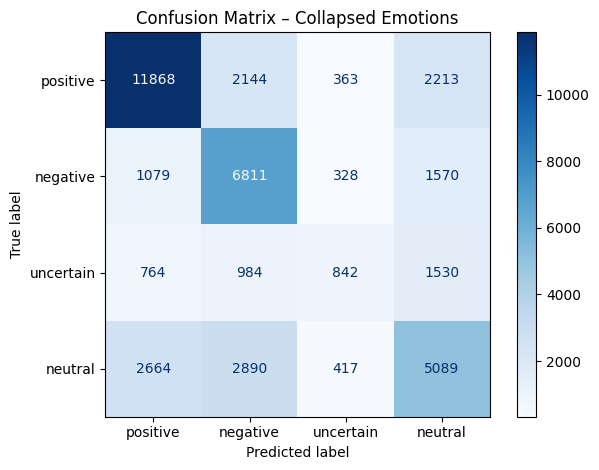

In [ ]:
cm = confusion_matrix(y_true, y_pred)

ConfusionMatrixDisplay(cm, display_labels=LABELS).plot(
    cmap="Blues", values_format="d"
)

plt.title("Confusion Matrix – Collapsed Emotions")
plt.tight_layout()
plt.show()


## Word Cloud

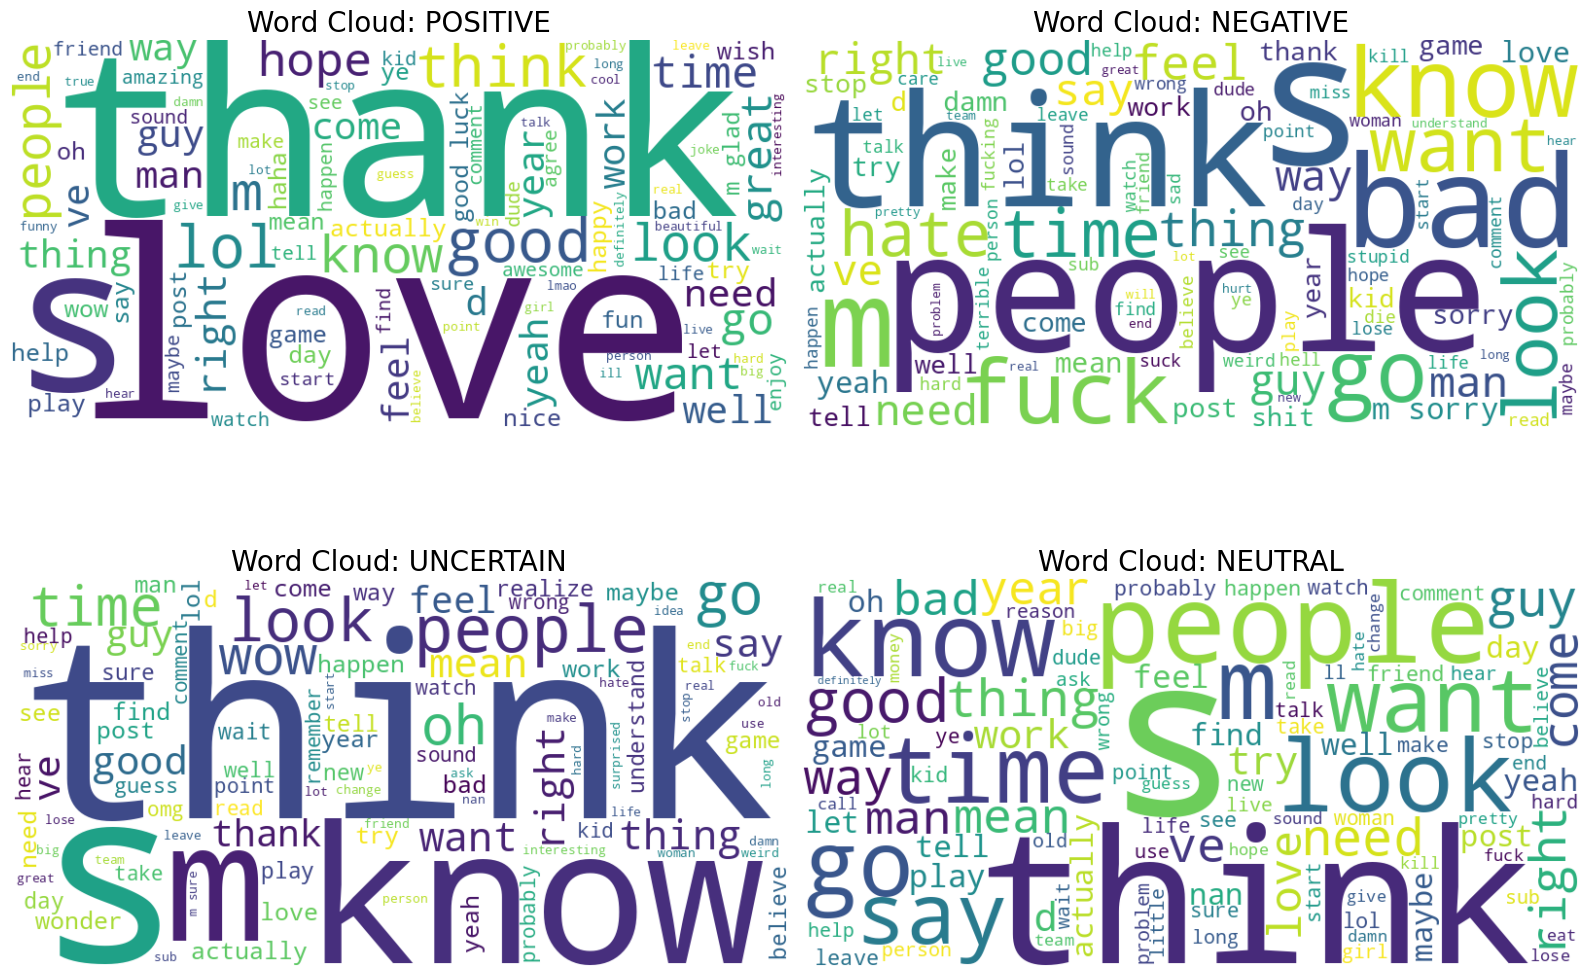

In [10]:
from wordcloud import WordCloud, STOPWORDS

def generate_emotion_wordclouds(dataframe, emotion_labels):
    """
    Generates a 2x2 grid of word clouds for the specified emotion labels.
    """
    plt.figure(figsize=(16, 12))

    # Common English stopwords to filter out non-informative words
    stopwords = set(STOPWORDS)

    for i, label in enumerate(emotion_labels):
        # Filter the dataframe for samples belonging to the current emotion group
        text_subset = dataframe[dataframe[label] == 1]['cleaned_text'].astype(str)
        combined_text = " ".join(text_subset)

        # Create the word cloud
        wc = WordCloud(
            background_color='white',
            max_words=100,
            stopwords=stopwords,
            width=800,
            height=400,
            colormap='viridis'
        ).generate(combined_text)

        # Plotting in a 2x2 grid
        plt.subplot(2, 2, i + 1)
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f'Word Cloud: {label.upper()}', fontsize=20)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Emotion groups
emotion_groups = ['positive', 'negative', 'uncertain', 'neutral']

generate_emotion_wordclouds(df, emotion_groups)

## LIME Explanable

In [21]:
!pip install lime

from lime.lime_text import LimeTextExplainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from lime.lime_text import LimeTextExplainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from collections import defaultdict
from tqdm import tqdm

In [20]:
import seaborn as sns

In [16]:
def predictor(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(DEVICE)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.sigmoid(logits).cpu().numpy() # Sigmoid for multi-label
    return probs

In [17]:
def get_global_importance(dataframe, num_samples=100):
    explainer = LimeTextExplainer(class_names=LABELS)
    # Sample training data for efficiency
    sample_df = dataframe.sample(n=min(num_samples, len(dataframe)), random_state=42)

    # Dictionary to store weights: {label_index: {word: total_weight}}
    global_weights = {i: defaultdict(float) for i in range(len(LABELS))}

    print(f"Analyzing {len(sample_df)} samples to find global features...")
    for text in tqdm(sample_df['cleaned_text']):
        # Explain all 4 labels for this specific text
        exp = explainer.explain_instance(text, predictor, num_features=10, labels=range(len(LABELS)))

        for i in range(len(LABELS)):
            for word, weight in exp.as_list(label=i):
                global_weights[i][word] += abs(weight) # Summing absolute impact

    return global_weights

In [22]:
def plot_global_lime(global_weights):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, label in enumerate(emotion_labels):
        # Sort words by total weight and take top 5
        sorted_weights = sorted(global_weights[i].items(), key=lambda x: x[1], reverse=True)[:5]
        words = [x[0] for x in sorted_weights]
        weights = [x[1] for x in sorted_weights]

        sns.barplot(x=weights, y=words, ax=axes[i], palette="viridis")
        axes[i].set_title(f"Top 5 Global Features: {label.upper()}", fontsize=14)
        axes[i].set_xlabel("Aggregated LIME Weight")

    plt.tight_layout()
    plt.show()

Analyzing 100 samples to find global features...


100%|██████████| 100/100 [02:59<00:00,  1.79s/it]
/tmp/ipython-input-3439895512.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, ax=axes[i], palette="viridis")
/tmp/ipython-input-3439895512.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, ax=axes[i], palette="viridis")
/tmp/ipython-input-3439895512.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, ax=axes[i], palette="viridis")
/tmp/ipython-input-3439895512.py:11: FutureWarning: 

Passing `palette` without assigning `hue`

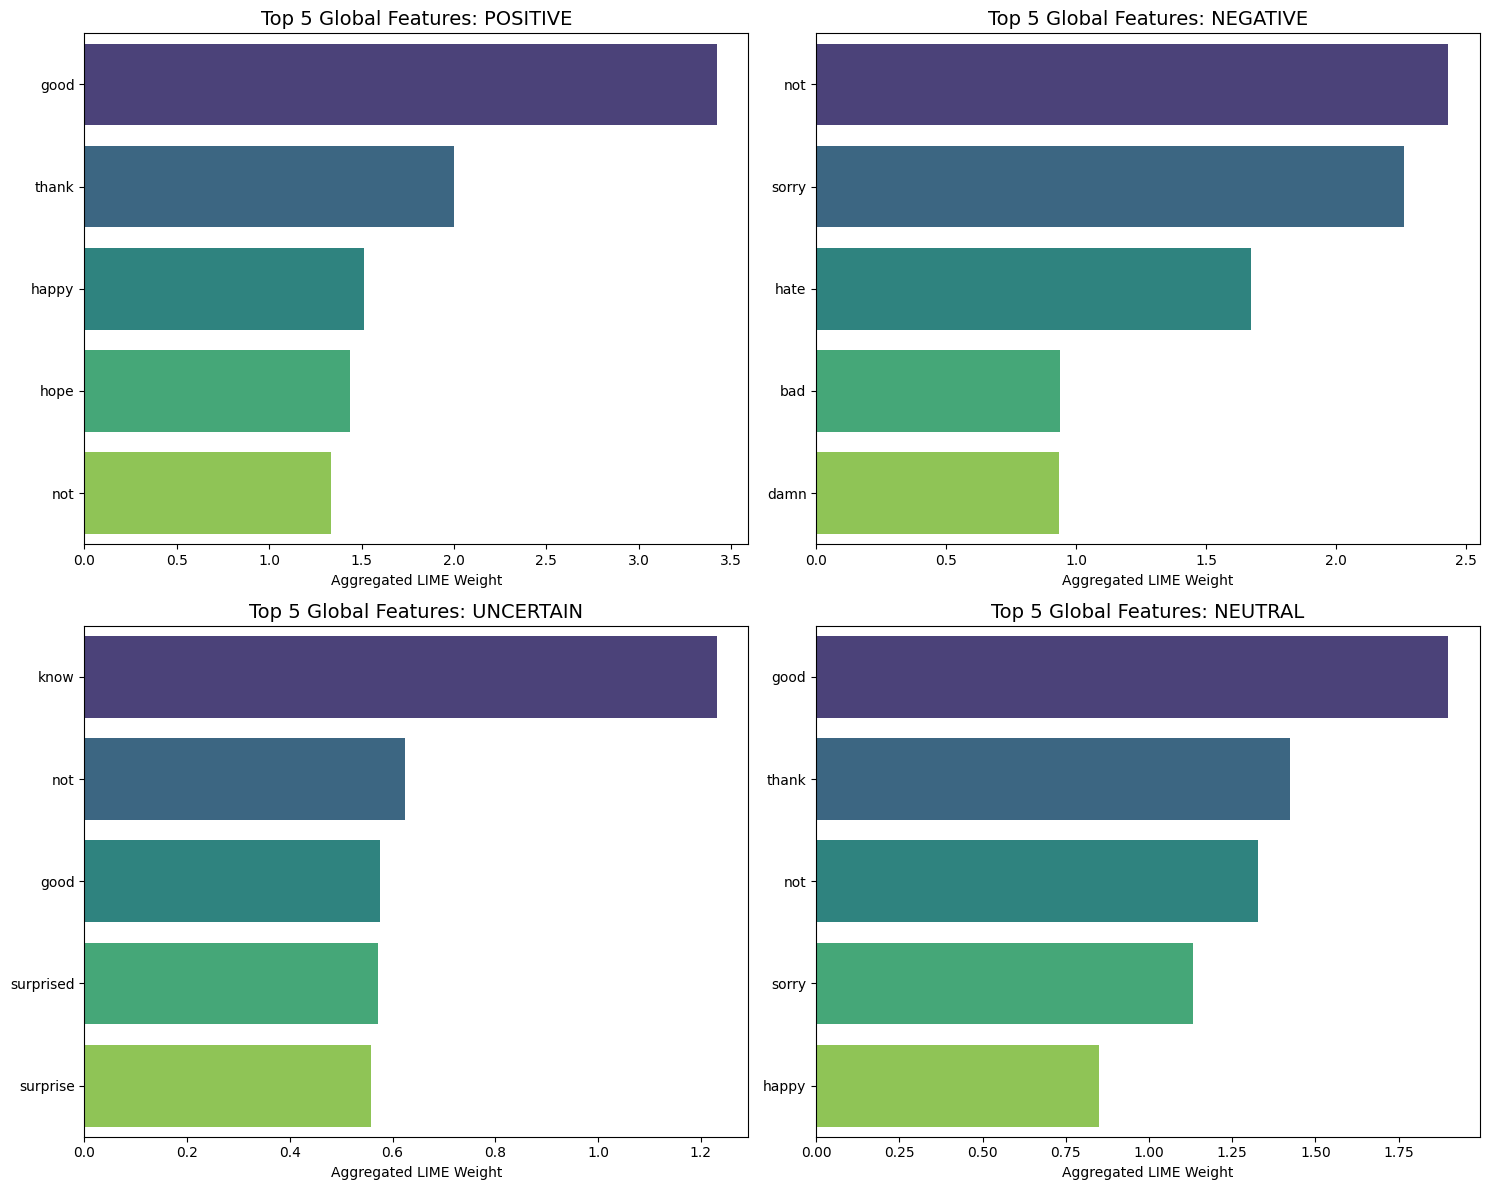

In [23]:
weights = get_global_importance(df, num_samples=100)
plot_global_lime(weights)